In [1]:
import sys
sys.path.append("..")

import numpy as np
import scipy.linalg as spl
import matplotlib.pyplot as plt
from utils import car_params as params

In [2]:
def wrap(phi):
    phi -= 2 * np.pi * np.floor((phi + np.pi) * 0.5/np.pi)
    return phi

class UKF:
    def __init__(self, t):
        self.dt = t

        self.wm = np.zeros(2 * params.n + 1)
        self.wc = np.zeros_like(self.wm)

        self.wm[0] = params.lamb / (params.n + params.lamb)
        self.wc[0] = self.wm[0] + (1 - params.alpha**2 + params.beta)

        self.wm[1:] = 1.0 / (2 * (params.n + params.lamb))
        self.wc[1:] = 1.0 / (2 * (params.n + params.lamb))

    def propagateState(self, state, v, w):
        theta = state[2]
        st = np.sin(theta)
        stw = np.sin(theta + w * self.dt)
        ct = np.cos(theta)
        ctw = np.cos(theta + w * self.dt)

        A = np.array([-v/w * st + v/w * stw,
                    v/w * ct - v/w * ctw,
                    w * self.dt])
        temp = state + A
        temp[2] = wrap(temp[2])
        return temp

    def propagateSigmaPts(self, Chi_x, Chi_u, v, w):
        theta = Chi_x[2,:]
        v = v + Chi_u[0,:]
        w = w + Chi_u[1,:]

        st = np.sin(theta)
        stw = np.sin(theta + w * self.dt)
        ct = np.cos(theta)
        ctw = np.cos(theta + w * self.dt)

        A = np.array([-v/w * st + v/w * stw,
                     v/w * ct - v/w * ctw,
                     w * self.dt])
        Chi_bar = Chi_x + A

        return Chi_bar

    def update(self, mu, Sigma, z, v, w):
        mu_a, Sig_a = self.augmentState(mu, Sigma, v, w)

        #Generate Sigma Points
        L = spl.cholesky(Sig_a, lower=True)
        Chi_a = self.generateSigmaPoints(mu_a, L)

        #propagation step
        Chi_x_bar = self.propagateSigmaPts(Chi_a[0:3,:], Chi_a[3:5,:], v, w) 
        mu_bar = np.sum(self.wm * Chi_x_bar, axis=1)
        mu_bar[2] = wrap(mu_bar[2])
        temp_x = Chi_x_bar - mu_bar.reshape((3,1))
        temp_x[2,:] = wrap(temp_x[2,:])
        Sigma_bar = np.sum(self.wc.reshape(2*params.n + 1, 1, 1) * np.einsum('ij, kj->jik', temp_x, temp_x), axis=0)

        #Measurement updates 
        for i in range(z.shape[1]):
            Z_bar = self.generateObservationSigmas(Chi_x_bar, Chi_a[5:, :], params.lms[:,i])
            z_hat = np.sum(self.wm * Z_bar, axis=1)
            temp_z = Z_bar - z_hat.reshape((2, 1))
            temp_z[1,:] = wrap(temp_z[1,:])
        
            S = np.sum(self.wc.reshape(2 * params.n + 1, 1, 1) * np.einsum('ij, kj->jik', temp_z, temp_z), axis=0)
            Sigma_xz = np.sum(self.wc.reshape(2 * params.n+1, 1, 1) * np.einsum('ij, kj->jik', temp_x, temp_z), axis=0)
        
            #Calculate the kalman gain
            K = Sigma_xz @ np.linalg.inv(S)
            innov = z[:,i] - z_hat
            innov[1] = wrap(innov[1])
            mu_bar = mu_bar + K @ (innov)
            mu_bar[2] = wrap(mu_bar[2])
            Sigma_bar = Sigma_bar - K @ S @ K.T

            #redraw sigma points (if not the last lm) and then reset stuff
            if not i == (z.shape[1] - 1):
                mu_a, Sig_a = self.augmentState(mu_bar, Sigma_bar, v, w)
                L = spl.cholesky(Sig_a, lower=True)
                Chi_a = self.generateSigmaPoints(mu_a, L)
                Chi_x_bar = Chi_a[0:3,:]
                temp_x = Chi_x_bar - mu_bar.reshape((3,1))

        return mu_bar, Sigma_bar, K


    def augmentState(self, mu, Sigma, v, w):
        M = np.diag([params.alpha1 * v**2 + params.alpha2 * w**2, params.alpha3 * v**2 + params.alpha4 * w**2])
        Q = np.diag([params.sigma_r**2, params.sigma_theta**2])

        mu_a = np.concatenate((mu, np.zeros(4)))
        Sig_a = spl.block_diag(Sigma, M, Q)

        return mu_a, Sig_a

    def generateSigmaPoints(self, mu_a, L):
        gamma = np.sqrt(params.n + params.lamb)
        Chi_a = np.zeros((params.n, 2 * params.n + 1))

        Chi_a[:,0] = mu_a
        Chi_a[:,1:params.n+1] = mu_a.reshape((params.n,1)) + gamma * L
        Chi_a[:, params.n+1:] = mu_a.reshape((params.n,1)) - gamma * L

        return Chi_a

    def generateObservationSigmas(self, Chi_x, Chi_z, lm):
        xy = Chi_x[0:2,:]
        thetas = Chi_x[2,:]

        ds = lm.reshape((2,1)) - xy
        r = np.sqrt(np.sum(ds**2, axis=0))

        psi = np.arctan2(ds[1,:], ds[0,:]) - thetas
        psi = wrap(psi)

        Z = np.vstack((r, psi)) + Chi_z
        return Z

Text(0.5, 1.0, 'Kalman Gain vs Time')

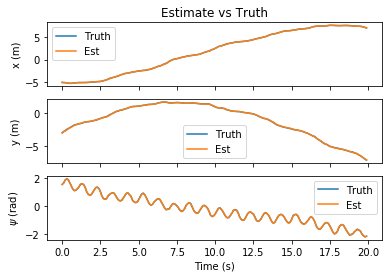

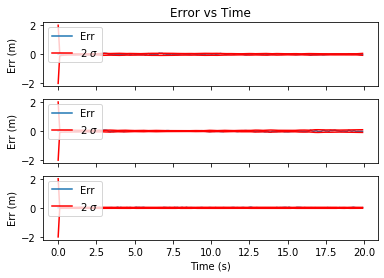

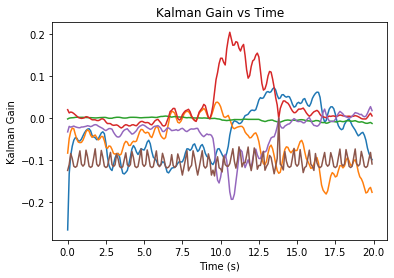

In [3]:
def generateVelocities(t):
    v = 1 + .5 * np.cos(2 * np.pi * 0.3 * t) #1 + .5 * np.cos(2 * np.pi * 0.2 * t)
    w = -0.2 + 2 * np.cos(2 * np.pi * 1.0 * t) # -0.2 + 2 * np.cos(2 * np.pi * 0.6 * t)

    return v, w

def getMeasurements(state):
    ds = params.lms - state[0:2].reshape((2,1))
    r = np.sqrt(np.sum(ds**2, axis=0)) + np.random.normal(0, params.sigma_r, size=(params.lms.shape[1]))
    theta = (np.arctan2(ds[1,:], ds[0,:]) - state[2]) + np.random.normal(0, params.sigma_theta, size=(params.lms.shape[1]))
    theta = wrap(theta)

    z = np.array([[r.flatten()], [theta.flatten()]]).reshape((2,params.num_lms))

    return z

t = np.arange(0, params.tf, params.dt)
vc, wc = generateVelocities(t)
v = vc + np.sqrt(params.alpha1 * vc**2 + params.alpha2 * wc**2) * np.random.randn(vc.size)
w = wc + np.sqrt(params.alpha3 * vc**2 + params.alpha4 * wc**2) * np.random.randn(wc.size)

ukf = UKF(params.dt)

x_hist = []
mu_hist = []
err_hist = []
x_covar_hist = []
y_covar_hist = []
psi_covar_hist = []
K_hist = []

x0 = params.x0
y0 = params.y0
phi0 = params.theta0
state = np.array([x0, y0, phi0])
dead_reckon = np.array([x0, y0, phi0])
mu = np.array([x0, y0, phi0])
Sigma = np.eye(3)

for i in range(t.size):
    #stuff for plotting
    x_hist.append(state)
    mu_hist.append(mu)
    err = state - mu
    err[2] = wrap(err[2])
    err_hist.append(err)
    x_covar_hist.append(Sigma[0,0])
    y_covar_hist.append(Sigma[1,1])
    psi_covar_hist.append(Sigma[2,2])

    state = ukf.propagateState(state, v[i], w[i])
    zt = getMeasurements(state)
    mu, Sigma, K = ukf.update(mu, Sigma, zt, vc[i], wc[i])
    dead_reckon = ukf.propagateState(dead_reckon, vc[i], wc[i])

    K_hist.append(K)

fig1, ax1 = plt.subplots(nrows=3, ncols=1, sharex=True)
x_hist = np.array(x_hist).T
mu_hist = np.array(mu_hist).T
ax1[0].plot(t, x_hist[0,:], label="Truth")
ax1[0].plot(t, mu_hist[0,:], label="Est")
ax1[0].set_ylabel("x (m)")
ax1[0].legend()
ax1[1].plot(t, x_hist[1,:], label="Truth")
ax1[1].plot(t, mu_hist[1,:], label="Est")
ax1[1].set_ylabel("y (m)")
ax1[1].legend()
ax1[2].plot(t, x_hist[2,:], label="Truth")
ax1[2].plot(t, mu_hist[2,:], label="Est")
ax1[2].set_xlabel("Time (s)")
ax1[2].set_ylabel("$\psi$ (rad)")
ax1[2].legend()
ax1[0].set_title("Estimate vs Truth")

fig2, ax2 = plt.subplots(nrows=3, ncols=1, sharex=True)
err_hist = np.array(err_hist).T
x_err_bnd = np.sqrt(np.array(x_covar_hist)) * 2
y_err_bnd = np.sqrt(np.array(y_covar_hist)) * 2
psi_err_bnd = np.sqrt(np.array(psi_covar_hist)) * 2
ax2[0].plot(t, err_hist[0,:], label="Err")
ax2[0].plot(t, x_err_bnd, 'r', label="2 $\sigma$")
ax2[0].plot(t, -x_err_bnd, 'r')
ax2[0].set_ylabel("Err (m)")
ax2[0].legend()
ax2[1].plot(t, err_hist[1,:], label="Err")
ax2[1].plot(t, y_err_bnd, 'r', label="2 $\sigma$")
ax2[1].plot(t, -y_err_bnd, 'r')
ax2[1].set_ylabel("Err (m)")
ax2[1].legend()
ax2[2].plot(t, err_hist[2,:], label="Err")
ax2[2].plot(t, psi_err_bnd, 'r', label="2 $\sigma$")
ax2[2].plot(t, -psi_err_bnd, 'r')
ax2[2].set_ylabel("Err (m)")
ax2[2].set_xlabel("Time (s)")
ax2[2].legend()
ax2[0].set_title("Error vs Time")

plt.figure(4)
K_hist = np.array(K_hist)
plt.plot(t, K_hist[:,0,0])
plt.plot(t, K_hist[:,1,0])
plt.plot(t, K_hist[:,2,0])
plt.plot(t, K_hist[:,0,1])
plt.plot(t, K_hist[:,1,1])
plt.plot(t, K_hist[:,2,1])
plt.xlabel("Time (s)")
plt.ylabel("Kalman Gain")
plt.title("Kalman Gain vs Time")